<a href="https://colab.research.google.com/github/M-Harrington/SnowComp/blob/main/baseline_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Drive

In [ ]:
#@title Mount drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Setup

In [ ]:
#@title Installs
# Important library for many geopython libraries
!apt install gdal-bin python-gdal python3-gdal &> /dev/null
# Install rtree - Geopandas requirment
!apt install python3-rtree &> /dev/null
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git &> /dev/null
# Install descartes - Geopandas requirment
!pip install descartes &> /dev/null
!pip install geopandas rioxarray &> /dev/null

In [ ]:
#@title Imports
import gdal
import itertools
import math
import os
import random
import time

import numpy as np
import geopandas as gpd
import pandas as pd

from datetime import datetime, timedelta
from osgeo import gdal, gdalconst
from scipy.interpolate import UnivariateSpline
from scipy.stats import pearsonr
from sklearn import linear_model, metrics
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold 
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression

import plotly
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

pd.options.mode.chained_assignment = None 
DATA_PATH = 'drive/MyDrive/fall21/snowcast/data/'
WEATHER_DIR = DATA_PATH + 'weather/'
PRED_PATH = DATA_PATH + 'predictions/'

START_DATE = datetime(2012, 6, 30)
END_DATE = datetime(2021, 6, 29)

gdal.UseExceptions()

# Get main data sources

In [ ]:
#@title Read in data
metadata = pd.read_csv(DATA_PATH + 'ground_measures_metadata.csv')
train_inp = pd.read_csv(DATA_PATH + 'ground_measures_train_features.csv')
test_inp = pd.read_csv(DATA_PATH + 'ground_measures_test_features.csv')
train_labels = pd.read_csv(DATA_PATH + 'train_labels.csv')
grid_cells = gpd.read_file(DATA_PATH + 'grid_cells.geojson')
submission_format = gpd.read_file(DATA_PATH + 'submission_format.csv')

In [ ]:
#@title Get metadata for grid cells
states = gpd.read_file(DATA_PATH + 'states/cb_2018_us_state_5m.shp')\
    .rename({'NAME': 'state'}, axis=1)
cell_metadata = gpd.sjoin(grid_cells, states[['geometry', 'state']])\
    .drop_duplicates(subset='cell_id')\
    .drop(['index_right'], axis=1)
cell_metadata['centroid'] = cell_metadata['geometry'].centroid
cell_metadata['longitude'] = cell_metadata['centroid'].x
cell_metadata['latitude'] = cell_metadata['centroid'].y
cell_metadata = cell_metadata[['cell_id', 'state', 'longitude', 'latitude']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning:

CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:4269


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




In [ ]:
#@title Format dfs
def get_rmse(df, actual='actual_snowpack', predicted='snowpack'):
    return ((df[actual] - df[predicted]) ** 2).mean() ** 0.5

def pivot_df(df, id_col, ignore_cols=None):
    if not ignore_cols:
        ignore_cols = []
    date_cols = [x for x in df.columns if x not in [id_col] + ignore_cols]
    dfs = []
    for day in date_cols:
        day_df = df[[id_col, day]].rename({day: 'snowpack'}, axis=1)
        day_df['date'] = day
        dfs.append(day_df)
    return pd.concat(dfs)

def get_day_of_season(doy):
    return doy + 365 - 335 if doy < 335 else doy - 335

def add_time_cols(df):
    df['date'] = pd.to_datetime(df['date'])
    df['doy'] = df['date'].dt.dayofyear
    df['dos'] = df['doy'].apply(get_day_of_season)
    df['year'] = df['date'].dt.year
    df['season'] = df['year']
    df.loc[df['doy'] < 335, 'season'] -= 1
    return df

def clean_train_test(df, id_col='station_id', metadata_df=None):
    df = pivot_df(df, id_col)
    if metadata_df is not None:
        df = df.merge(metadata_df)
    return add_time_cols(df)


train = clean_train_test(train_inp.rename({'Unnamed: 0': 'station_id'}, axis=1),
                         metadata_df=metadata)
train2 = clean_train_test(train_labels, 'cell_id', cell_metadata).dropna()
train_full = pd.concat([train2.rename({'cell_id': 'station_id'}, axis=1).assign(datatype='labels'),
                        train.drop(['elevation_m', 'name'], axis=1).assign(datatype='ground')])

test = clean_train_test(
    test_inp.rename({'Unnamed: 0': 'station_id'}, axis=1), metadata_df=metadata)\
    .rename({'snowpack': 'actual_snowpack'}, axis=1).dropna()\
    .merge(train[['station_id', 'state']].drop_duplicates())

to_predict = clean_train_test(submission_format.drop('geometry', axis=1), 'cell_id', cell_metadata)

# round(test['actual_snowpack'].std(), 3)

In [ ]:
#@title Helpers to read in weather data
def get_date(x):
    return datetime.strptime(x.split('_')[0], '%Y%m%d')

def read_train_weather(fname, var, dir, verbose=False):
    if verbose:
        print('Reading', fname)
    df = pd.read_csv(WEATHER_DIR + dir + fname)\
           .rename({'cell_id': 'station_id'}, axis=1)
    df_04 = pivot_df(df, 'station_id', ignore_cols=[x for x in df.columns if x.endswith('_16')])
    df_16 = pivot_df(df, 'station_id', ignore_cols=[x for x in df.columns if x.endswith('_04')])

    df_04['date'] = df_04['date'].apply(get_date)
    df_16['date'] = df_16['date'].apply(get_date)

    return df_04.rename({'snowpack': var + '_04'}, axis=1)\
                .merge(df_16.rename({'snowpack': var + '_16'}, axis=1), how='outer')

def get_missing_rows(df):
    stations = df['station_id'].unique()
    start, end = df['date'].min(), df['date'].max()
    dates = [start + timedelta(i) for i in range((end - start).days + 1)]
    comb = pd.DataFrame(list(itertools.product(stations, dates)), columns=['station_id', 'date'])
    return df.merge(comb, how='outer')

def unravel_weather(df, p):
    return pd.concat([
        df.drop([p + '_16'], axis=1).rename({p + '_04': p}, axis=1).assign(reading='04'),
        df.drop([p + '_04'], axis=1).rename({p + '_16': p}, axis=1).assign(reading='16')])\
        .sort_values(['date', 'reading'])

# Fill nas with most recent prior observation
def fill_na(df, p):
    unraveled = unravel_weather(df, p)
    unraveled[p] = unraveled.groupby('station_id')[p].fillna(method='ffill').to_list()
    return unraveled[unraveled['reading'] == '04']\
        .rename({p: p + '_04'}, axis=1)\
        .drop({'reading'}, axis=1)\
        .merge(unraveled[unraveled['reading'] == '16']\
               .rename({p: p + '_16'}, axis=1)
               .drop({'reading'}, axis=1))

# Fill nas with most recent prior observation from same time of day (proxy for high/low temp)
def fill_na_temp(df, p):
    df = df.sort_values(['date'])
    df[p + '_04'] = df.groupby('station_id')[p + '_04'].fillna(method='ffill').to_list()
    df[p + '_16'] = df.groupby('station_id')[p + '_16'].fillna(method='ffill').to_list()
    return df

In [ ]:
#@title Read training weather data
# from scratch

def get_weather_var(prefix, is_temp=False):
    files = [x for x in os.listdir(WEATHER_DIR + 'train_csvs/') if x.startswith(prefix + '_2')]
    df = pd.concat([read_train_weather(x, prefix, 'train_csvs/') for x in files])
    df = get_missing_rows(df)
    return fill_na_temp(df, prefix) if is_temp else fill_na(df, prefix)

# snow_depth = get_weather_var('snow_depth')
# snow_depth.to_csv(WEATHER_DIR + 'aggregated_train_csvs/snow_depth.csv', index=False)

# water_eq = get_weather_var('snow_depth_water_eq')
# water_eq.to_csv(WEATHER_DIR + 'aggregated_train_csvs/snow_depth_water_eq.csv', index=False)

# snow_cover = get_weather_var('snow_cover')
# snow_cover.to_csv(WEATHER_DIR + 'aggregated_train_csvs/snow_cover.csv', index=False)

# temp = get_weather_var('temp', is_temp=True)
# temp.to_csv(WEATHER_DIR + 'aggregated_train_csvs/temp.csv', index=False)
# print('temp done')

# frozen_precip = get_weather_var('pct_frozen_precip')
# frozen_precip.to_csv(WEATHER_DIR + 'aggregated_train_csvs/pct_frozen_precip.csv', index=False)
# print('frozen_precip done')

# precip = get_weather_var('precip')
# precip.to_csv(WEATHER_DIR + 'aggregated_train_csvs/precip.csv', index=False)
# print('precip done')

# from file
def read_file(fname):
    path = WEATHER_DIR + 'aggregated_train_csvs/%s.csv' % fname
    df = pd.read_csv(path)
    df['date'] = pd.to_datetime(df['date'])
    c = [x for x in df.columns if x.endswith('_04') or x.endswith('_16')]
    if len(df[df[c[0]] != df[c[1]]]) == 0:
        print('WARNING', c)
    return df

snow_depth_orig = read_file('snow_depth')
temp_orig = read_file('temp')
water_eq_orig = read_file('snow_depth_water_eq')
snow_cover_orig = read_file('snow_cover')
frozen_precip_orig = read_file('pct_frozen_precip')
precip_orig = read_file('precip')



WARNING ['precip_04', 'precip_16']


In [ ]:
#@title Misc helpers
def rmse(a, p):
    return round(((a - p) ** 2).mean() ** 0.5, 4)

def quick_predict(train_df, test_df, cols, get_preds=False):
    lm = LinearRegression().fit(train_df[cols], train_df['snowpack'])
    train_rmse = rmse(train_df['snowpack'], lm.predict(train_df[cols]))
    test_preds = lm.predict(test_df[cols])
    if get_preds:
        return train_rmse, test_preds
    else:
        test_rmse = rmse(test_df['actual_snowpack'], test_preds)
        corr = round(pearsonr(test_df['actual_snowpack'], test_preds)[0], 4)
        return train_rmse, test_rmse, corr


def interact(df, cont_cols, dummy_col):
    keep_cols = list(set(df.columns) - set([dummy_col] + cont_cols))
    dummies = pd.get_dummies(df, columns=[dummy_col])
    dummy_cols = [x for x in dummies.columns if x.startswith(dummy_col)]
    int_df = dummies[keep_cols]

    for cc in cont_cols:
        for dc in dummy_cols:
            int_df[cc + '_' + dc] = dummies[cc] * dummies[dc]

    return int_df

def get_tt_cols(df):
    df['dos_2'] = df['dos'] ** 2
    return interact(df, ['dos', 'dos_2'], 'state')

def write_formatted_preds(preds_df, outpath):
    preds_df = preds_df[['cell_id', 'date', 'snowpack']]
    preds_df['date'] = preds_df['date'].apply(lambda x: x.strftime('%Y-%m-%d'))
    submission = preds_df.pivot(index='cell_id', columns='date', values='snowpack')\
                        .reset_index()\
                        .sort_values('cell_id')

    assert sorted(submission.columns) == sorted(submission_format.columns[:-1])
    assert sorted(submission['cell_id']) == sorted(submission_format['cell_id'])

    submission.to_csv(PRED_PATH + '%s.csv' % outpath, index=False)

def format_state(orig_df):
    df = orig_df.dropna()
    df['dos_2'] = df['dos'] ** 2
    return interact(df, ['dos', 'dos_2'], 'state')






# Get processed data sources

In [ ]:
#@title Get snow depth data
snow_depth = snow_depth_orig.copy()
snow_depth['daily_depth'] = snow_depth['snow_depth_04']
snow_depth.loc[snow_depth['snow_depth_16'] > snow_depth['snow_depth_04'], 'daily_depth'] =\
    snow_depth['snow_depth_16']

snow_depth = snow_depth.sort_values('date')
snow_depth['delta'] = (snow_depth['daily_depth'] -
                       snow_depth.groupby('station_id')['daily_depth'].shift(1))
snow_depth = add_time_cols(snow_depth.drop(['snow_depth_04', 'snow_depth_16'], axis=1))

# try different variables
snow_depth['delta'] = snow_depth['delta'].fillna(0)
snow_depth = snow_depth.sort_values(['season', 'dos'])
snow_depth['max_depth'] = snow_depth.groupby(['station_id', 'season'])['daily_depth'].cummax()

snow_depth['snowfall'] = snow_depth['delta'].apply(lambda x: max(0, x))
snow_depth['snowmelt'] = snow_depth['delta'].apply(lambda x: min(0, x))

snow_depth['snowfall'] = snow_depth.groupby(['station_id', 'season'])['snowfall'].cumsum()
snow_depth['snowmelt'] = snow_depth.groupby(['station_id', 'season'])['snowmelt'].cumsum()

snow_depth['net_snow'] = snow_depth['snowfall'] + snow_depth['snowmelt']


In [ ]:
#@title Get temperature data
temp = temp_orig.copy()
temp['date'] = pd.to_datetime(temp['date'])

temp['low'] = temp['temp_04']
temp.loc[temp['temp_16'] < temp['temp_04'], 'low'] = temp['temp_16']

temp['high'] = temp['temp_16']
temp.loc[temp['temp_16'] < temp['temp_04'], 'high'] = temp['temp_04']

temp = add_time_cols(temp)
temp = temp[(temp['date'] >= train['date'].min()) &
            (temp['date'] <= test['date'].max()) &
            (temp['dos'] <= test['dos'].max())]


In [ ]:
#@title "Degree day" helpers
def get_integral(slope, intercept, start, end):
    l = slope / 2 * start ** 2 + intercept * start
    r = slope / 2 * end ** 2 + intercept * end
    return r - l

def get_ddays(x):
    min_temp, max_temp = x['low'], x['high']
    # print(min_temp, max_temp)
    if min_temp > 0:
        neg_area = 0
        pos_area = (max_temp - min_temp) / 2 + min_temp
    elif max_temp <= 0:
        pos_area = 0
        neg_area = (min_temp - max_temp) / 2 - min_temp
    else:
        x_int = (-1 * min_temp) / (max_temp - min_temp)
        slope = (max_temp - min_temp)
        neg_area = -1 * get_integral(slope, min_temp, 0, x_int)
        pos_area = get_integral(slope, min_temp, x_int, 1)
    return neg_area, pos_area


In [ ]:
#@title Get degree days
t0 = time.time()
temp['ddays'] = temp.apply(get_ddays, axis=1)
print(time.time() - t0)

temp['ddays_neg'] = temp['ddays'].apply(lambda x: x[0])
temp['ddays_pos'] = temp['ddays'].apply(lambda x: x[1])
temp = temp.sort_values('dos')

temp['ddays_neg_cum'] = temp.groupby(['station_id', 'season'])['ddays_neg'].cumsum()
temp['ddays_pos_cum'] = temp.groupby(['station_id', 'season'])['ddays_pos'].cumsum()


21.949269771575928


In [ ]:
#@title Get outliers in training data
outliers = train_full.sort_values('dos')
outliers['delta'] = \
    (outliers['snowpack'] - outliers.groupby(['station_id', 'season'])['snowpack'].shift(1)) /\
    (outliers['dos'] - outliers.groupby(['station_id', 'season'])['dos'].shift(1))
outliers = outliers.dropna()

i = 2
non_outliers = outliers[(outliers['delta'] < i) & (outliers['delta'] > -i)]
outliers = outliers[(outliers['delta'] >= i) | (outliers['delta'] <= -i)]
outliers = outliers[['station_id', 'season']].drop_duplicates()
non_outliers = non_outliers[['station_id', 'season']].drop_duplicates()




# Workspace

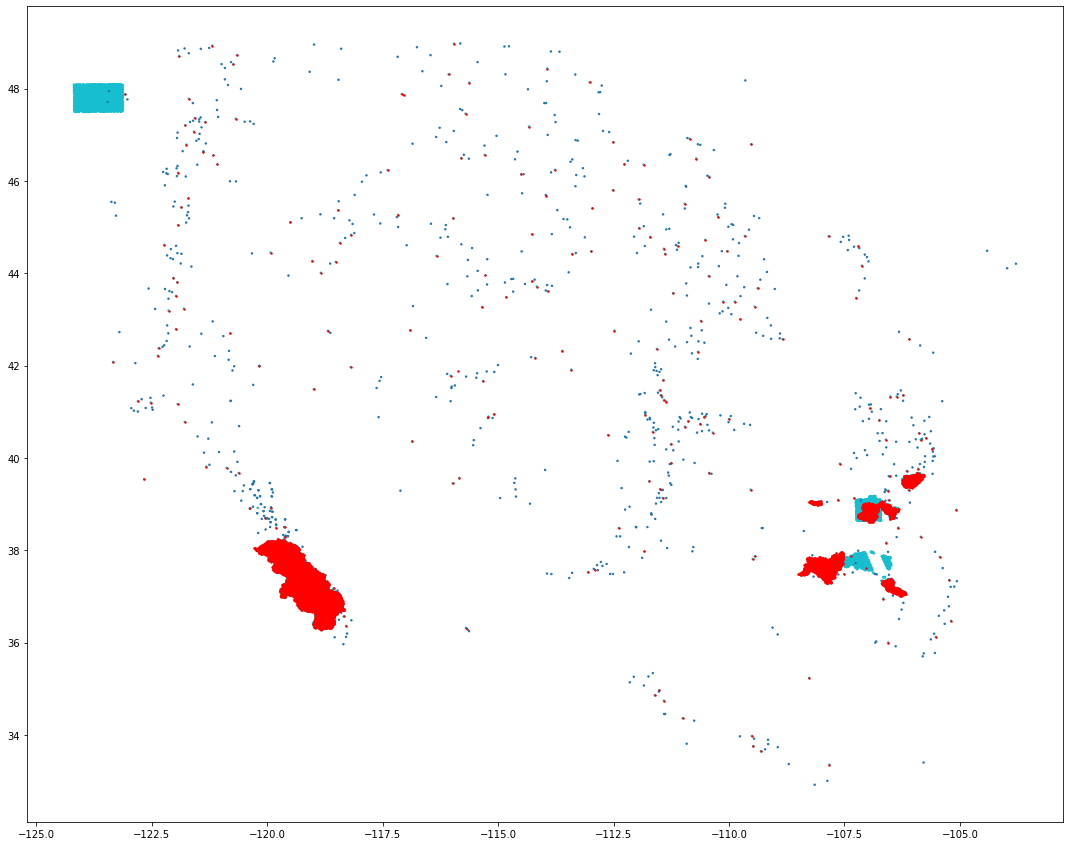

In [ ]:
#@title Plot train/test data points
train_plot = train_full.drop_duplicates(subset='station_id')
train_plot = gpd.GeoDataFrame(train_plot,
    geometry=gpd.points_from_xy(train_plot['longitude'], train_plot['latitude']))

pred_plot = to_predict.drop_duplicates(subset='cell_id')
pred_plot = gpd.GeoDataFrame(pred_plot,
    geometry=gpd.points_from_xy(pred_plot['longitude'], pred_plot['latitude']))

f, ax=plt.subplots(figsize=(20, 15))
train_plot.plot(column='datatype', ax=ax, markersize=2)
pred_plot.plot(color='red', ax=ax, markersize=2)


In [ ]:
#@title Get id to region map
regions = grid_cells.dissolve(by='region').reset_index()
regions = regions[regions['region'] != 'other']
regions['geometry'] = regions['geometry'].convex_hull.buffer(0.2)

id_to_region = gpd.GeoDataFrame(
    metadata, geometry=gpd.points_from_xy(metadata['longitude'], metadata['latitude']))\
    [['station_id', 'geometry']]
id_to_region = pd.concat([id_to_region,
    grid_cells[['cell_id', 'geometry']].rename({'cell_id': 'station_id'}, axis=1)])
id_to_region = gpd.sjoin(id_to_region, regions, how='left')
id_to_region['region'] = id_to_region['region'].fillna('other')
id_to_region = id_to_region[['station_id', 'region']]

train_reg = train_full.merge(id_to_region)
test_reg = test.merge(id_to_region)
to_predict_reg = to_predict.merge(id_to_region.rename({'station_id': 'cell_id'}, axis=1))



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning:

Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning:

CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326




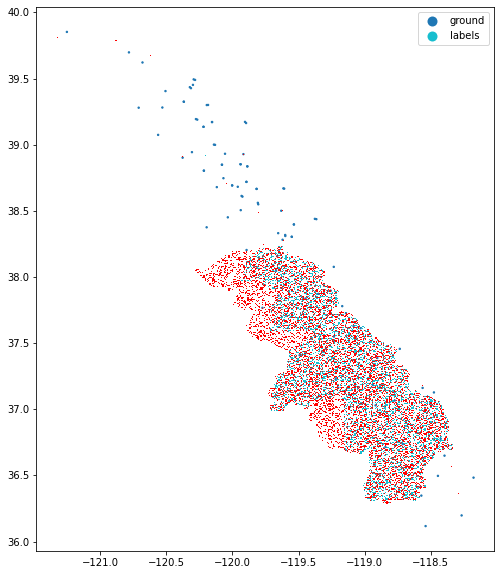

In [ ]:
#@title Plot train/test data -- Sierras
train_locs = id_to_region[id_to_region['station_id'].isin(train_full['station_id'])]\
    .merge(train_full[['datatype', 'station_id']].drop_duplicates())
test_locs = id_to_region[id_to_region['station_id'].isin(to_predict['cell_id'])]

f, ax = plt.subplots(figsize=(10, 10))
train_locs[train_locs['region'] == 'sierras'].plot(ax=ax, markersize=2, column='datatype', legend=True)
test_locs[test_locs['region'] == 'sierras'].plot(ax=ax, markersize=2, color='red')

In [ ]:
#@title RF helpers
def format_rf(df):
    df = df.dropna()
    # df['snowpack_cat'] = df['snowpack'].apply(lambda x: 0 if x < 15 else 1) # not used right now
    df['dos_2'] = df['dos'] ** 2
    # df = pd.get_dummies(df, columns=['datatype'])
    # df = pd.get_dummies(df, columns=['region'])
    return pd.get_dummies(df, columns=['state'])

def get_trained_rf(train_df, holdout_ids, rf_cols, fuzz, max_depth, n_estimators=100):
    print(fuzz, max_depth, n_estimators)
    train_holdout = train_df[~train_df['station_id'].isin(holdout_ids)]
    train_c = format_rf(train_holdout).dropna()

    if fuzz > 0:
        train_c['latitude'] += np.random.normal(0, fuzz, len(train_c))
        train_c['longitude'] += np.random.normal(0, fuzz, len(train_c))

    rf = RandomForestRegressor(max_depth=max_depth, n_estimators=n_estimators, random_state=123)\
        .fit(train_c[rf_cols], train_c['snowpack'])

    preds = rf.predict(train_c[rf_cols])
    print("Train Std Dev:", round(train_c['snowpack'].std(), 3)," Train RMSE: ", rmse(train_c['snowpack'], preds))
    return rf, preds

def eval_test(rf, rf_cols, test_df, p = True):
    rf_df = format_rf(test_df.rename({'actual_snowpack': 'snowpack'}, axis=1))
    preds = rf.predict(rf_df[rf_cols])

    if p:
        print("Test Std Dev:", round(rf_df['snowpack'].std(), 3), "Test RMSE: ", rmse(rf_df['snowpack'], preds))
    
    return preds

def get_rmse_all(df1, df2, df3, print_name, return_score=False):
    temp_preds =  pd.concat((
        (df1['actual_snowpack'] - df1['preds']) ** 2 ,
        (df2['actual_snowpack'] - df2['preds']) ** 2 ,
        (df3['actual_snowpack'] - df3['preds']) ** 2))

    rmse_val =  temp_preds.mean()** .5
    print("Difference Std Dev:",round(temp_preds.std(), 3) , "RMSE:", round(rmse_val, 3), print_name ) 
    if return_score:
        return rmse_val

def get_rmse_all_train(sierra_preds, sierra_train,
                        rocky_preds, rocky_train,
                        other_preds, other_train):
    sierra_train, rocky_train, other_train =sierra_train.dropna(), rocky_train.dropna(), other_train.dropna() 
    temp_diff = np.concatenate( (
        (sierra_preds - sierra_train['snowpack'].to_numpy())**2,
        (rocky_preds - rocky_train['snowpack'].to_numpy())**2,                  
        (other_preds - other_train['snowpack'].to_numpy())**2
    )) 
    print("Difference Std Dev:",round(temp_diff.std(), 3) , "RMSE:", round(temp_diff.mean()**.5, 3), "  TRAIN")

In [ ]:
#@title Get train/test dfs by region
random.seed(123)

def holdout(train_df):
    stations = train_df.loc[train_df['datatype'] == 'ground', 'station_id'].unique()
    random.shuffle(stations)
    return list(stations[:int(len(stations) / 10)])

sierra_train = train_reg[train_reg['region'] == 'sierras']
sierra_test = test_reg[test_reg['region'] == 'sierras']
sierra_holdout_list = holdout(sierra_train)
sierra_holdout = sierra_test[sierra_test['station_id'].isin(sierra_holdout_list)]

rocky_train = train_reg[train_reg['region'] == 'central rockies']
rocky_test = test_reg[test_reg['region'] == 'central rockies']
rocky_holdout_list = holdout(rocky_train)
rocky_holdout = rocky_test[rocky_test['station_id'].isin(rocky_holdout_list)]

other_train = train_reg.copy()
other_test = test_reg[test_reg['region'] == 'other']
other_holdout_list = holdout(other_train)
other_holdout = other_test[other_test['station_id'].isin(other_holdout_list)]


In [ ]:
#@title Check for and remove outliers in training data -- not currently using

# sierra_train.groupby(['station_id', 'season'])['snowpack'].std().mean() # 9.61
# outliers = sierra_train.sort_values('dos')
# outliers['delta'] = \
#     (outliers['snowpack'] - outliers.groupby(['station_id', 'season'])['snowpack'].shift(1)) /\
#     (outliers['dos'] - outliers.groupby(['station_id', 'season'])['dos'].shift(1))
# outliers = outliers.dropna()
# print(outliers['snowpack'].std())

# upper = 2
# lower = 0.2

# non_outliers = outliers.loc[(outliers['delta'] < upper) & (outliers['delta'] > -lower), 
#                             ['station_id', 'season']].drop_duplicates()\
#                             .rename({'cell_id': 'station_id'}, axis=1)
# sierra_train = sierra_train.merge(non_outliers)


In [ ]:
#@title Train RF by region
baseline_cols = ['dos', 'dos_2', 'latitude', 'longitude']

#train_df, holdout_ids, rf_cols, fuzz, max_depth, n_estimators=100
train = True
if train:
    rf_sierra, sierra_preds = get_trained_rf(sierra_train, sierra_holdout_list, baseline_cols, 0.1, 10, 300)
    rf_rocky, rocky_preds = get_trained_rf(rocky_train, rocky_holdout_list, baseline_cols, 0.3, 10, 300)
    rf_other, other_preds = get_trained_rf(other_train, other_holdout_list, baseline_cols, 0.3, 10, 300)

print('\nSIERRAS')
sierra_test['preds'] = eval_test(rf_sierra, baseline_cols, sierra_test)
sierra_holdout['preds'] = eval_test(rf_sierra, baseline_cols, sierra_holdout)

print('ROCKIES')
rocky_test['preds'] = eval_test(rf_rocky, baseline_cols, rocky_test)
rocky_holdout['preds'] = eval_test(rf_rocky, baseline_cols, rocky_holdout)

print('OTHER')
other_test['preds'] = eval_test(rf_other, baseline_cols, other_test)
other_holdout['preds'] = eval_test(rf_other, baseline_cols, other_holdout)

print('\nOVERALL')
get_rmse_all_train(sierra_preds, sierra_train[~sierra_train['station_id'].isin(sierra_holdout_list)],
                        rocky_preds, rocky_train[~rocky_train['station_id'].isin(rocky_holdout_list)],
                        other_preds, other_train[~other_train['station_id'].isin(other_holdout_list)])

get_rmse_all(sierra_test, rocky_test,other_test, "  TEST")
get_rmse_all(sierra_holdout, rocky_holdout,other_holdout, "  HOLDOUT")


SIERRAS
0.1 10 300
15.887 12.0419
8.443 9.4768
8.191 10.9949


In [ ]:
#@title Train full RFs
#note we should make final predictions on all data, so above are overwritten
train = True
if train:
    rf_sierra, sierra_preds = get_trained_rf(sierra_train, [], baseline_cols, 0.1, 10, 300)
    rf_rocky, rocky_preds = get_trained_rf(rocky_train, [], baseline_cols, 0.3, 10, 300)
    rf_other, other_preds = get_trained_rf(other_train, [], baseline_cols, 0.3, 10, 300)

get_rmse_all_train(sierra_preds, sierra_train,
                        rocky_preds, rocky_train,
                        other_preds, other_train)

In [ ]:
#@title Predict submission dataset
reg_to_rf = [('sierras', rf_sierra), ('central rockies', rf_rocky), ('other', rf_other)]
predicted = []

for reg, rf in reg_to_rf:
    reg_df = to_predict_reg[to_predict_reg['region'] == reg]
    pred_df = format_rf(reg_df)
    pred_df['snowpack'] = rf.predict(pred_df[baseline_cols])
    predicted.append(pred_df)

predicted = pd.concat(predicted)
write_formatted_preds(predicted[['cell_id', 'snowpack', 'date']], 'rf_by_region_sierra_label_only')

344736
159030
12996


In [ ]:
#@title CV code
random.seed(123)
sierra_stations = sierra_train.loc[sierra_train['datatype'] == 'ground', 'station_id'].unique()
random.shuffle(sierra_stations)
block_sz = int(len(sierra_stations) / 5)

preds = []

for i in range(5):
    print(i)
    start = i * block_sz
    end = (i + 1) * block_sz if i < 9 else len(sierra_stations)
    sierra_holdout_list = sierra_stations[start: end]
    
    rf_10, _ = get_trained_rf(sierra_train, sierra_holdout_list, baseline_cols, 0, 10, 300)
    # rf_15, _ = get_trained_rf(sierra_train, sierra_holdout_list, baseline_cols, 0, 15)
    # rf_20, _ = get_trained_rf(sierra_train, sierra_holdout_list, baseline_cols, 0, 20)

    sierra_holdout = sierra_test[sierra_test['station_id'].isin(sierra_holdout_list)]
    sierra_holdout['preds_10'] = eval_test(rf_10, baseline_cols, sierra_holdout)
    # sierra_holdout['preds_15'] = eval_test(rf_15, baseline_cols, sierra_holdout)
    # sierra_holdout['preds_20'] = eval_test(rf_20, baseline_cols, sierra_holdout)

    preds.append(sierra_holdout)

preds = pd.concat(preds)


In [ ]:
#@title Naive CV
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=12345)

scores = []
for train_index , test_index in kf.split(train_reg):
    train , test = train_reg.iloc[train_index,:], train_reg.iloc[test_index,:]

    sierra_train = train[train['region'] == 'sierras']
    sierra_test = (test[test['region'] == 'sierras']).dropna()

    rocky_train = train[train['region'] == 'central rockies']
    rocky_test = (test[test['region'] == 'central rockies']).dropna()

    other_train = train.copy()
    other_test = (test[test['region'] == 'other']).dropna()


    rf_sierra, sierra_preds = get_trained_rf(sierra_train, [], baseline_cols, 0.1, 10, 300)
    rf_rocky, rocky_preds = get_trained_rf(rocky_train, [], baseline_cols, 0.3, 10, 300)
    rf_other, other_preds = get_trained_rf(other_train, [], baseline_cols, 0.3, 10, 300)

    sierra_test['preds'] = eval_test(rf_sierra, baseline_cols, sierra_test, p = False)
    rocky_test['preds'] = eval_test(rf_rocky, baseline_cols, rocky_test, p = False)
    other_test['preds'] = eval_test(rf_other, baseline_cols, other_test, p = False)
    
    sierra_test.rename({'snowpack': 'actual_snowpack'}, axis=1, inplace=True)
    rocky_test.rename({'snowpack': 'actual_snowpack'}, axis=1, inplace=True)
    other_test.rename({'snowpack': 'actual_snowpack'}, axis=1, inplace=True)

    scores.append(get_rmse_all(sierra_test, rocky_test,other_test, "", return_score = True))

print("\n",scores,"\n", np.sqrt((np.array(scores)**2).sum()/k ))